# 08. PyTorch Paper Replicating

Replicating [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
](https://arxiv.org/abs/2010.11929): Vision Transformers.

## 0. Setup

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get Data

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders


### 2.1 Prepare transforms for images

In [5]:
# Create image size (from table 3 in ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into DataLoaders

The ViT paper mentions a batch size of 4096, meaning 4096 images need to fit in the GPU memory at a time. Google Colab free tier GPUs cannot handle this so we will lower the batch size.

**NOTE:** `pin_memory=True` avoids unnecessary copying of memory between CPU and GPU by 'pinning' the content (not letting it move to CPU).

In [6]:
BATCH_SIZE = 32                 # Depends on the hardware

# Creating dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1d270da0850>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shape
image.shape, label

KeyboardInterrupt: 

(-0.5, 223.5, 223.5, -0.5)

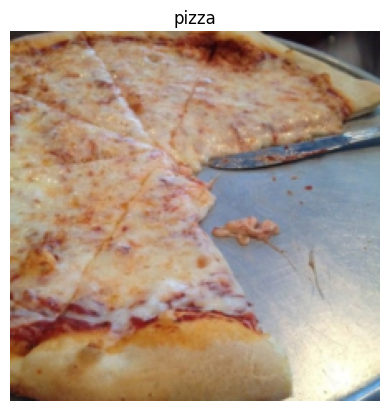

In [ ]:
plt.imshow(image.permute(1, 2, 0))          # Rearrange the dimensions to (C, H, W)
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating the ViT paper: an overview

### 3.1 Inputs and outputs, layers and blocks

* **Layer:** Takes an input, performs a function on it and returns the output
* **Block:** A collection of layers, takes an input, performs a series of functions on it and returns an output.
* **Architecture (or model)**: A collection of blocks, takes an input, performs a series of functions on it, and returns an output.

### 3.2 Getting specific: What's ViT is made of?

We'll focus on
1. The model architecture

2. 4 equations in section 3.1

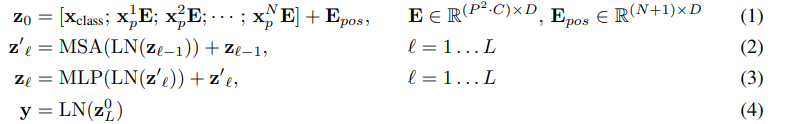

3. Table 1 (the ViT Base model):

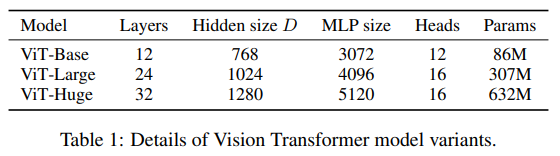

### 3.2.1 Exploring the model architecture
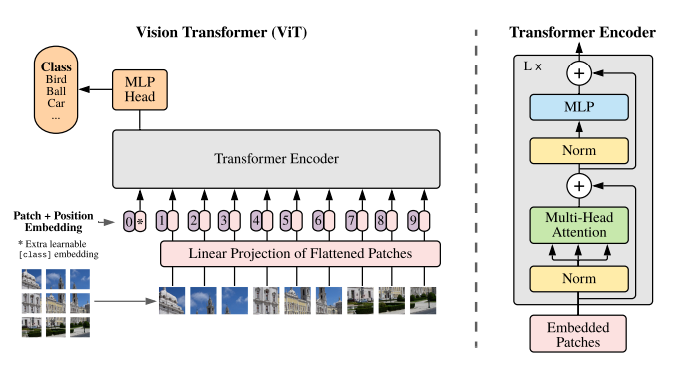

The ViT architecure is comprised of several stages:
* **Patch + Position Embeddings (inputs):** Turns the image into sequence of patches & adds a position number to identify the order in which the patches come in.
* **Linear projection of flattened patches (Embedded patches):** The image patches get turned into embeddings. The benefit of using embeddings is that it is a learnable representation of the image (usually in the form of a vector) and can improve with training, which is not possible if we directly use the image values.
* **Layer Normalization (Norm):** It is a technique for regularizing a neural network, can be implemented in PyTorch using `torch.nn.LayerNorm()`.
* **Multi-Head Attention:** A multi-head self-attention layer, used to run an attention mechanism several times in parallel.
* **Multi-layer perceptron (MLP):** A multi-layered feedforward neural network. In the ViT paper, the authors use 2 linear layers with GeLU activation function and a dropout layer after each linear layer for regularization.
* **Transformer Encoder:** The collection of all the layers listed above form the Transformer Encoder. The ViT architecture comprises of a number of Encoder layers stacked on top of each other. There are 2 skip connections in the Encoder layer denoted by '+' symbols. Skip connections mean directly feeding the input to an immediate layer/layers as well as the next layer.
* **MLP Head:** This is the output layer, it converts the learned features of an input to a class output. We can also call it the classifier head.

### 3.2.2 Exploring the 4 equations
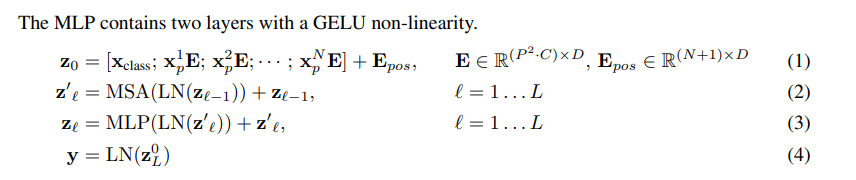

**Equation 1:**
The transformer uses constant latent vector size `D` through all of its layers, so we flatten the patches and map to `D` dimensions with a trainable linear projection (Eqn 1). We refer to the output of this projection as the patch embeddings. Position embeddings are added to the patch embeddings to retain positional information as in images, the position also matters. We use standard learnable 1D position embeddings.

In vector form, the embedding may look like:
`x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]`, here each element in the vector is learnable.

**Equation 2 and 3:**
The transformer encoder uses alternating layers of multi-head self attention (MSA) and MLP blocks. Layer Normalization (LN) is applied before every block and residual connections (skip connections) after every block.

We'll call the layer in equation 2 as MSA block, which looks something like this:
`x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input`

We'll call the layer in equation 3 as MLP block, which looks something like this:
`x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block`

**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$. Basically, it is the classification layer used for classifying, e.g. if it's a pizza, steak or sushi.

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN). In our case, it may look something like this:
`y = Linear_layer(LN_layer(x_output_MLP_block[0]))`


### 3.2.7 Exploring Table 1
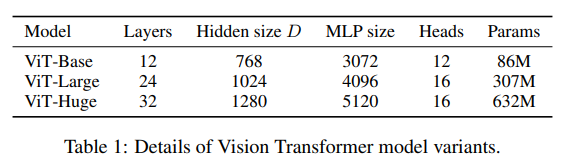

Breaking down the hyperparameters
* **Layers:** The number of transformer encoder blocks, each with a MSA and a MLP block.
* **Hidden Size `D`:** This is the size of the vector that our image gets converted into (embedding dimension). Bigger embedding dimension = more info captured = better results, but it also means more compute.
* **MLP Size:** Number of hidden units in each MLP layer.
* **Heads:** Number of heads in multi-headed attention layers
* **Params:** Total number of parameters in the model.

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding


Remember, an embedding is a learnable representation of some form, usually a vector.

`Image -> patches -> patch embeddings`

Let's go through the opening paragraph of section 3.1 of the paper
> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Let's break it down:
* Size of patch embeddings: $D$
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.

* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (patch size).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

### 4.1 Calculating patch embedding input and output shapes by hand

We'll use a patch size $P$ of 16 since the best performing version of ViT-Base uses it (Table 5)

In [ ]:
height, width = 224, 224            # Training resolution is 224 as per the paper
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / (patch_size ** 2))       # N
print(f"Number of patches (N): {number_of_patches}\nWith image height (H={height}), weight (W={width}) and patch size (P={patch_size})")

Number of patches (N): 196
With image height (H=224), weight (W=224) and patch size (P=16)


**Creating the input & output shapes of the patch embedding layer:**

Input: The image starts as 2D with size ${H \times W \times C}$.
Output: The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [ ]:
# Input shape (size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape (size of patches)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (Single Image): {embedding_layer_input_shape}")
print(f"Output shape (Single image flattened into 2D patches): {embedding_layer_output_shape}")

Input shape (Single Image): (224, 224, 3)
Output shape (Single image flattened into 2D patches): (196, 768)


### 4.2 Turning a single image into patches
Now we know the ideal input and output shapes for our patch embedding layer, let's move towards making it.

(-0.5, 223.5, 223.5, -0.5)

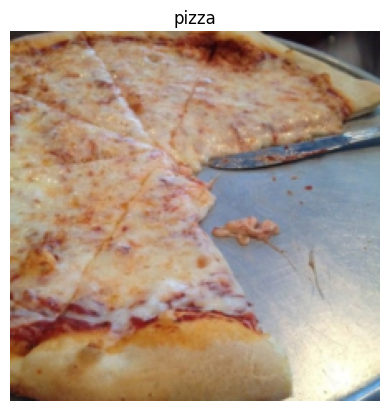

In [ ]:
# Viewing a sample image
image_permuted = image.permute(1, 2, 0)     # For matplotlib
plt.imshow(image_permuted)      
plt.title(class_names[label])
plt.axis(False)

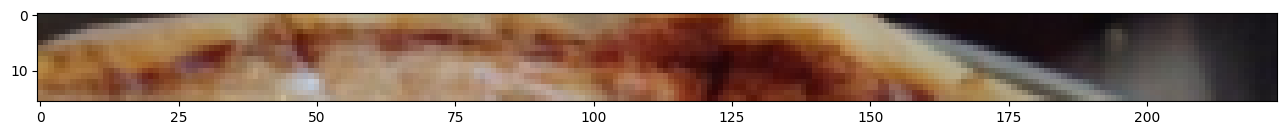

In [ ]:
# Viewing the top row of the patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size:])

Now let's convert it into patches

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


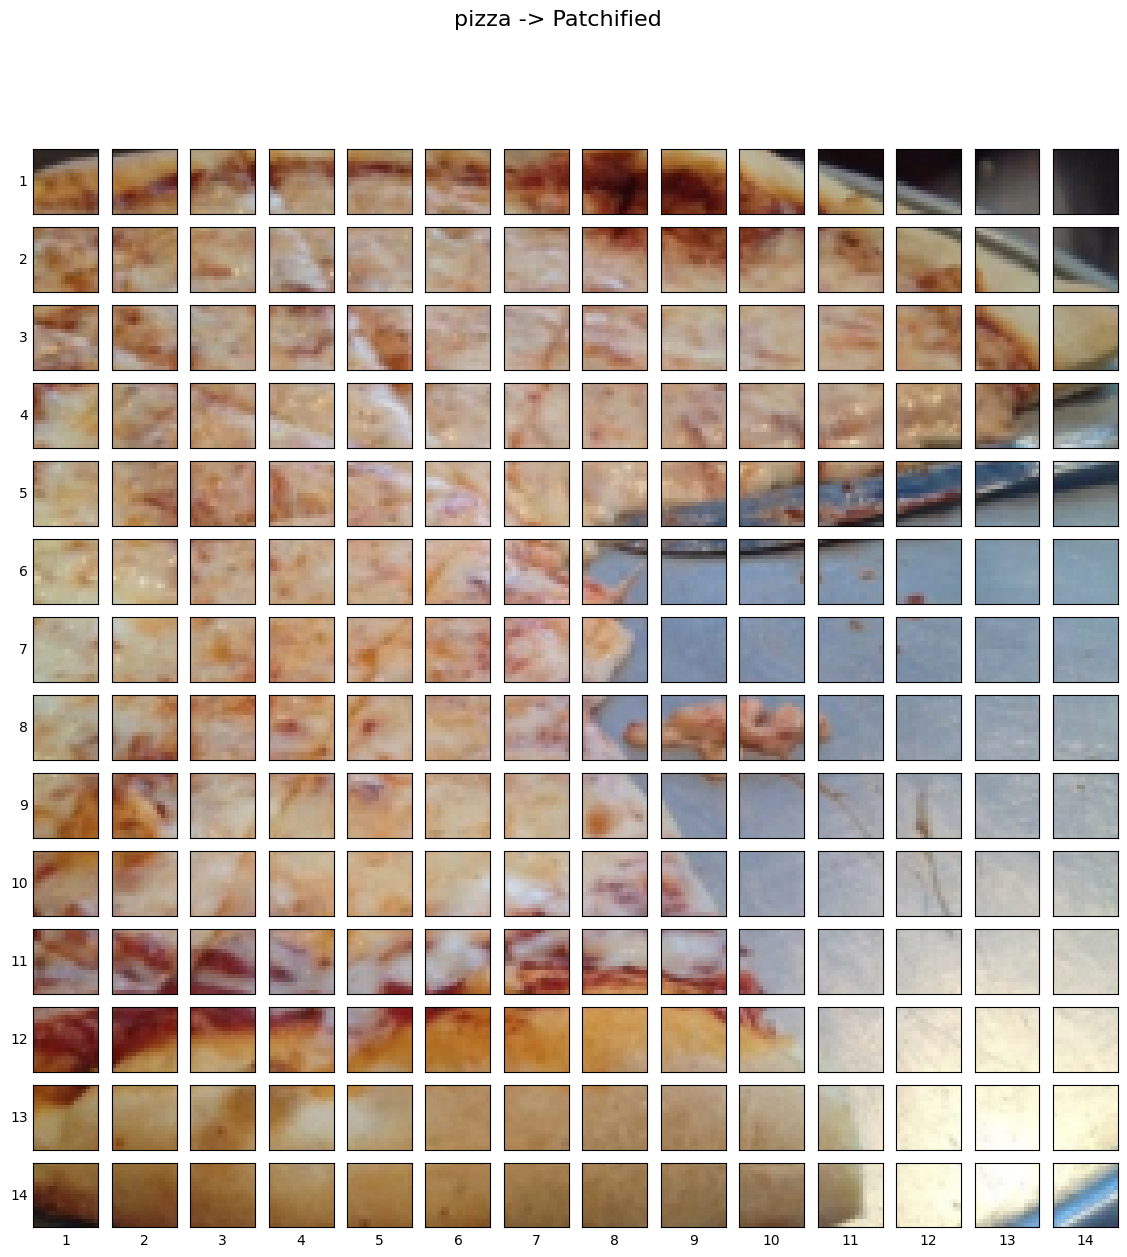

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()


## 4.3 Creating image patches with `torch.nn.Conv2d()`

By setting the `kernel_size` and `stride` parameters of `torch.nn.Conv2d()` = `patch_size`, we can create image patches.

In [ ]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,           # Number of color channels
                   out_channels=768,        # Embedding size
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0
                   )

(-0.5, 223.5, 223.5, -0.5)

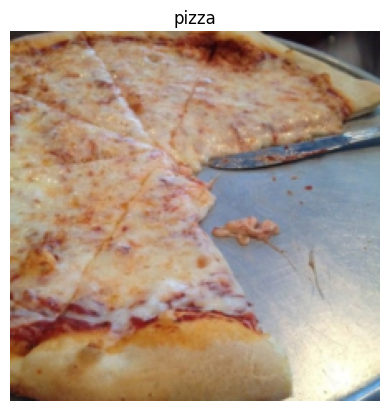

In [ ]:
plt.imshow(image.permute(1, 2, 0))  # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)

In [ ]:
# Passing the image through the conv layer
image_out_of_conv = conv2d(image.unsqueeze(0))  # Add extra dimension for batch size
print(image_out_of_conv.shape)          # After conv layer: (batch_size, embedding_size, feature_map_height, feature_map_width)

torch.Size([1, 768, 14, 14])


Showing random feature maps: [537, 189, 648, 351, 173]


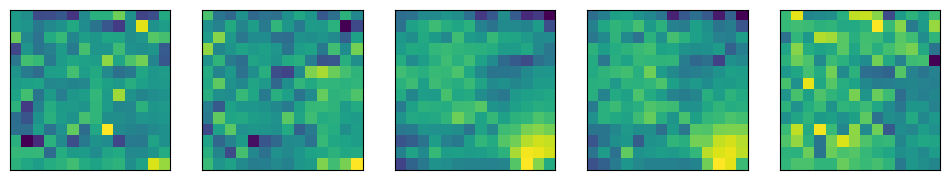

In [ ]:
# Plot 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5)      # Randomly select 5 feature maps
print(f"Showing random feature maps: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]    # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

These *features* change over time as the neural network learns which is why they can be called **learnable embeddings**.

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.2560, -0.3052, -0.1515, -0.1439, -0.1512, -0.1910, -0.1607,
           -0.1030, -0.1209, -0.1477, -0.2403, -0.1773, -0.1537, -0.1428],
          [-0.2770, -0.2695, -0.2361, -0.2659, -0.2918, -0.2482, -0.3037,
           -0.2611, -0.2739, -0.2419, -0.2054, -0.2201, -0.2526, -0.2047],
          [-0.1827, -0.2345, -0.2756, -0.2642, -0.2864, -0.2778, -0.3105,
           -0.2924, -0.3195, -0.3121, -0.2685, -0.2801, -0.2162, -0.2572],
          [-0.2370, -0.2845, -0.2627, -0.2852, -0.3621, -0.2913, -0.2574,
           -0.3014, -0.2683, -0.3155, -0.2942, -0.2401, -0.1581, -0.1664],
          [-0.2773, -0.3042, -0.2609, -0.2412, -0.2918, -0.2868, -0.2905,
           -0.3268, -0.2394, -0.1990, -0.2304, -0.1466, -0.0812, -0.0645],
          [-0.2736, -0.3170, -0.3290, -0.2617, -0.2879, -0.2914, -0.2954,
           -0.2154, -0.2723, -0.3106, -0.3215, -0.2445, -0.2360, -0.2565],
          [-0.2665, -0.2718, -0.2910, -0.2863, -0.2710, -0.2620, -0.2948,
           -0.2822, -0.2314, -0.

## 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

In [ ]:
(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

'Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]'

In [ ]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2,   # flatten feature_map_height (dimension 2)
                     end_dim=3)     # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


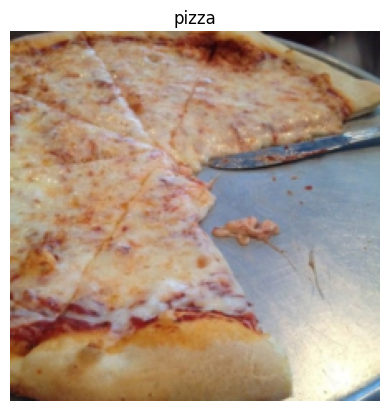

In [ ]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0))              # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Our desired output for the 1st layer is `(196, 768)` while our current shape is `(1, 768, 196)`.

In [ ]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


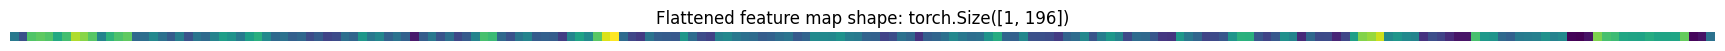

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]    # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [ ]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.2560, -0.3052, -0.1515, -0.1439, -0.1512, -0.1910, -0.1607, -0.1030,
          -0.1209, -0.1477, -0.2403, -0.1773, -0.1537, -0.1428, -0.2770, -0.2695,
          -0.2361, -0.2659, -0.2918, -0.2482, -0.3037, -0.2611, -0.2739, -0.2419,
          -0.2054, -0.2201, -0.2526, -0.2047, -0.1827, -0.2345, -0.2756, -0.2642,
          -0.2864, -0.2778, -0.3105, -0.2924, -0.3195, -0.3121, -0.2685, -0.2801,
          -0.2162, -0.2572, -0.2370, -0.2845, -0.2627, -0.2852, -0.3621, -0.2913,
          -0.2574, -0.3014, -0.2683, -0.3155, -0.2942, -0.2401, -0.1581, -0.1664,
          -0.2773, -0.3042, -0.2609, -0.2412, -0.2918, -0.2868, -0.2905, -0.3268,
          -0.2394, -0.1990, -0.2304, -0.1466, -0.0812, -0.0645, -0.2736, -0.3170,
          -0.3290, -0.2617, -0.2879, -0.2914, -0.2954, -0.2154, -0.2723, -0.3106,
          -0.3215, -0.2445, -0.2360, -0.2565, -0.2665, -0.2718, -0.2910, -0.2863,
          -0.2710, -0.2620, -0.2948, -0.2822, -0.2314, -0.2336, -0.2366, -0.2219,
          -0.248

## 4.5 Turning the ViT patch embedding layer into a PyTorch module

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable parameter

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with apropriate variables
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,  # only flatten the feature map dimensions into a single vector
                                  end_dim=3) 
        
    # Define the forward method
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1)     # adjust so the embedding is on the final dimension

In [ ]:
# Let's try it out
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))     # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


Let's get a summary of our `PatchEmbedding` layer

In [ ]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)     # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image,      # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## 4.6 Creating the class token embedding

We need to *preprend a learnable embedding to the sequence of embedded patches* as mentioned in the paper.

In [ ]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.5910,  0.1058, -0.0333,  ...,  0.1634, -0.1392,  0.2608],
         [-0.6325,  0.2201, -0.0199,  ...,  0.2746, -0.3497,  0.1202],
         [-0.5202,  0.0222, -0.2370,  ...,  0.4112, -0.2377,  0.1893],
         ...,
         [-0.9924,  0.2903, -0.2638,  ...,  0.7542, -0.4617,  0.3450],
         [-0.8791,  0.2300, -0.1697,  ...,  0.5660, -0.3721,  0.3249],
         [-0.4532,  0.0909, -0.2855,  ...,  0.5710, -0.3543,  0.2058]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


We need to create a learnable embedding in the shape of `embedding_dimension` and then add it to the `number_of_patches` dimension

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),  # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True)  # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


> **Note:** Here we're only creating the class token embedding as `torch.ones()` for demonstration purposes, in reality, you'd likely create the class token embedding with `torch.randn()` (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

Now we've got the class token embedding, let's prepend it to our sequence of image patches, `patch_embedded_image`.

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)    # concat on first dimension (number of tokens)

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5910,  0.1058, -0.0333,  ...,  0.1634, -0.1392,  0.2608],
         [-0.6325,  0.2201, -0.0199,  ...,  0.2746, -0.3497,  0.1202],
         ...,
         [-0.9924,  0.2903, -0.2638,  ...,  0.7542, -0.4617,  0.3450],
         [-0.8791,  0.2300, -0.1697,  ...,  0.5660, -0.3721,  0.3249],
         [-0.4532,  0.0909, -0.2855,  ...,  0.5710, -0.3543,  0.2058]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## 4.7 Creating the position embedding

Let's create the position embedding.

Let's find out more by reading section 3.1 of the ViT paper (bold mine):
>Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

By "retain positional information" the authors mean they want the architecture to know what "order" the patches come in. As in, patch two comes after patch one and patch three comes after patch two and on and on.

In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5910,  0.1058, -0.0333,  ...,  0.1634, -0.1392,  0.2608],
          [-0.6325,  0.2201, -0.0199,  ...,  0.2746, -0.3497,  0.1202],
          ...,
          [-0.9924,  0.2903, -0.2638,  ...,  0.7542, -0.4617,  0.3450],
          [-0.8791,  0.2300, -0.1697,  ...,  0.5660, -0.3721,  0.3249],
          [-0.4532,  0.0909, -0.2855,  ...,  0.5710, -0.3543,  0.2058]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

Equation 1 states that the position embeddings ($E_{pos} E_{pos}$) should have the shape $(N + 1) \times D(N + 1) \times D$

where $N = \frac{HW}{P^2}$ = number of patches

and $D$ = size of patch embeddings

In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,   # +1 for class token
                                             embedding_dimension),
                                  requires_grad=True)   # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


> **Note:** Only creating the position embedding as torch.ones() for demonstration purposes, in reality, you'd likely create the position embedding with torch.randn() (start with a random number and improve via gradient descent).

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4090, 1.1058, 0.9667,  ..., 1.1634, 0.8608, 1.2608],
         [0.3675, 1.2201, 0.9801,  ..., 1.2746, 0.6503, 1.1202],
         ...,
         [0.0076, 1.2903, 0.7362,  ..., 1.7542, 0.5383, 1.3450],
         [0.1209, 1.2300, 0.8303,  ..., 1.5660, 0.6279, 1.3249],
         [0.5468, 1.0909, 0.7145,  ..., 1.5710, 0.6457, 1.2058]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


> Notice how the values of each of the elements in the embedding tensor increases by 1 (this is because of the position embeddings being created with `torch.ones())`.

## 4.8 Putting it all together: from image to embedding

In [ ]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


We've successfully converted the equation into code!

## 5. Equation 2: Multi-Head Attention

Equation 2: $z_l^{'} = MSA(LN(z_{l-1})) + z_{l-1},        l = 1 ... L$

This indicates a Multi-Head Attention (MSA) layer wrapping a LayerNorm (LN) layer with a residual connection.

We'll refer to this equation as the MSA block.

### 5.1 The LayerNorm (LN) layer

Layer Normalization (`torch.nn.LayerNorm()`) It normalizes the input on the last dimension. It improves training time and generalizability of the model.

### 5.2 The Multi-Head Self Attention (MSA) Layer

Since our input is a sequence of image patches rather than words (the context in which attention was originally used), self-attention and in turn multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image.

The MSA layer has triple embedding input. This is known as query, key, value input or qkv for short.

In our case, the triple embedding input will be three versions of the output of the Norm layer, one for query, key and value.

We can implement the MSA layer in PyTorch with `torch.nn.MultiheadAttention()` with the parameters:

* **embed_dim** - the embedding dimension from Table 1 (Hidden size $D$).
* **num_heads** - how many attention heads to use.
* **dropout** - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).
* **batch_first** - does our batch dimension come first

### 5.3 Replicating Equation 2 with PyTorch layers

In [ ]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768,     # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12,          # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0):     # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        #  4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
        # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,   # query embeddings
                                             key=x,     # key embeddings
                                             value=x,   # value embeddings
                                             need_weights=False)    # do we need the weights or just the layer outputs?
        return attn_output

In [ ]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP)

Equation 3: $z_l = MLP(LN(z_l^{'})) + z_l^{'},\;\;\;\;\;z = 1 ... L$

There's a residual connection in this layer.

### 6.1 The MLP layer(s)

MLP generally follows this pattern: `linear layer -> non-linear layer -> linear layer -> non-linear layer`

In this paper, it contains 2 layers with GeLU non-linearity (`torch.nn.GELU()`).

As mentioned in the Appendix B.1 (Training), every layer in the MLP block has a dropout layer (`torch.nn.Dropout()`)

### 6.2 Replicating Equation 3 with PyTorch layers

In [ ]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768,     # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072,         # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1):        # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), 
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim), 
            nn.Dropout(p=dropout)
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, 
                     mlp_size=3072, 
                     dropout=0.1) 

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 7. Create the Transformer Encoder

Encoder or autoencoder refers to a stack of layers that turns an input into some form of numerical representation.

### 7.1 Creating a Transformer Encoder by combining our custom made layers

In [ ]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768,   
                 num_heads:int=12, 
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [ ]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),   # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12, 
                                                             dim_feedforward=3072, 
                                                             dropout=0.1, 
                                                             activation="gelu", 
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. Putting it all together to create ViT

In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 num_transformer_layers:int=12, 
                 embedding_dim:int=768, 
                 mlp_size:int=3072,
                 num_heads:int=12, 
                 attn_dropout:float=0, 
                 mlp_dropout:float=0.1, 
                 embedding_dropout:float=0.1, 
                 num_classes:int=1000):     # Default for ImageNet but can customize this
        super().__init__() 

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [ ]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [ ]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## 9. Setting up training code for our ViT model

### 9.1 Creating an optimizer

We will be using the Adam optimizer. We'll set the learning rate of the optimizer to 0.003 as per Table 3 (according to the setting of ViT-* trained on ImageNet-1k).

### 9.2 Creating a loss function

We'll be using `torch.nn.CrossEntropyLoss()`

### 9.3 Training our ViT model

In [ ]:
from going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,               # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999),    # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3)      # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

### 9.4 What our training setup is missing

The main culprit can be scale. The original ViT paper uses a far larger amount of data to train the model.

### 9.5 Plot the loss curves of our ViT model

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

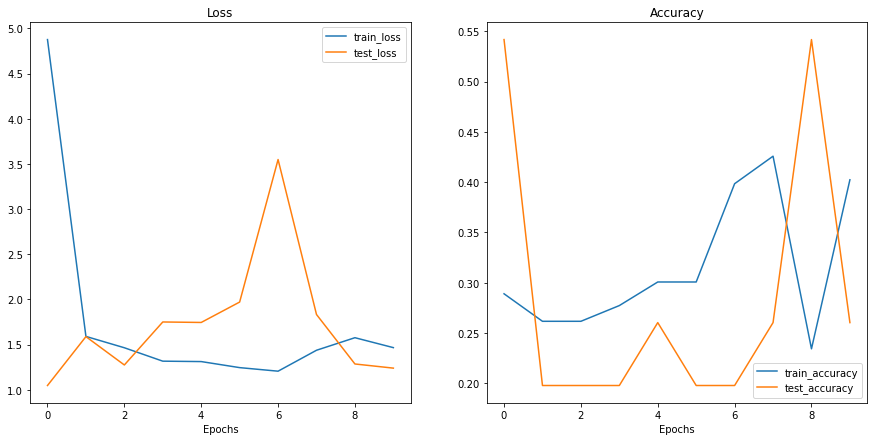

The loss and accuracy curves don't look too good. While the loss is decreasing overall by quite a bit, there's not much improvement in accuracy.

## 10. Using a pretrained ViT from `torchvision.models` on the same dataset

### 10.1 Why use a pretrained model?

Training SOTA models is getting increasingly expensive and affordable only for top labs. So it is getting harder to train these models ourselves but we can use these 'pre-trained' models through HuggingFace, TIMM, etc.

### 10.2 Getting a pretrained ViT model and creating a feature extractor

In [10]:
# Loading the model
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freezing the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Changing classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [11]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### 10.3 Preparing data for the pretrained ViT model

In [12]:
from helper_functions import download_data

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [13]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [14]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [15]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
test_dir=test_dir,
transform=pretrained_vit_transforms,
batch_size=32)

### 10.4 Train feature extractor ViT model

In [16]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

### 10.5 Plot feature extractor ViT model loss curves

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

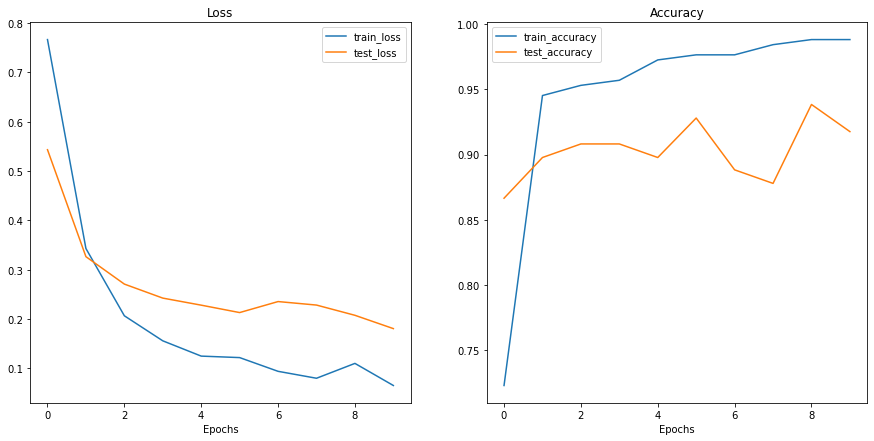

We achieve great loss and accuracy now.

### 10.6 Save feature extractor ViT model and check file size

In [ ]:
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

## 11. Make predictions on a custom image

import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)